## This code is to demo creation of a Dataframe Q&A pipeline.
Here we define the set of modules:
- Pandas prompt to infer pandas instructions from user query
- Pandas output parser to execute pandas instructions on dataframe, get back dataframe
- Response synthesis prompt to synthesize a final response given the dataframe
 


In [1]:
from llama_index.core.query_pipeline import (
    QueryPipeline as QP,
    Link,
    InputComponent,
)
from llama_index.llms.openai import OpenAI
from llama_index.core import PromptTemplate
import pandas as pd
from llama_index.experimental.query_engine.pandas import PandasInstructionParser
import os
from pathlib import Path


# CSV File Reader

This Python script does the following:

1. **Import Libraries**: Uses `os`, `pandas`, and `Path` for file operations and data handling.

2. **Set Base Directory**: Determines the base directory of the script, working in both script and interactive environments.

3. **Construct File Path**: Builds the path to the CSV file using the base directory.

4. **Check File Existence**: Verifies if the CSV file exists.

5. **Read CSV File**: Attempts to read the CSV file using pandas.

6. **Error Handling**: Manages potential errors like empty files or parsing issues.

7. **Display Data**: If successful, prints the first few rows of the dataframe.

The script is designed to robustly handle different environments and potential file-reading issues.

In [2]:
import os
import pandas as pd
from pathlib import Path

# Determine the base directory
try:
    # This will work when running as a script
    base_dir = Path(__file__).resolve().parent.parent
except NameError:
    # This will work in interactive environments like Jupyter
    base_dir = Path.cwd().parent

# Construct the path to the CSV file
csv_path = base_dir / "llama_index_basics" / "data" / "csv_data" / "ObesityDataSet.csv"

# Check if the file exists
if not csv_path.is_file():
    raise FileNotFoundError(f"The file {csv_path} does not exist.")

# Read the CSV file
try:
    df = pd.read_csv(csv_path, encoding='latin-1')
    df
    print(f"Successfully read {csv_path.name}")
    print(df.head())  # Display the first few rows
except pd.errors.EmptyDataError:
    print(f"The file {csv_path.name} is empty.")
except pd.errors.ParserError as e:
    print(f"Error parsing {csv_path.name}: {e}")
except Exception as e:
    print(f"An unexpected error occurred while reading {csv_path.name}: {e}")

# If you need to use the dataframe later in your code, it's available as 'df'

Successfully read ObesityDataSet.csv
    Age  Gender  Height  Weight Alcohol_Consulption High_Calorie_Food  \
0  21.0  Female    1.62    64.0                  no                no   
1  21.0  Female    1.52    56.0           Sometimes                no   
2  23.0    Male    1.80    77.0          Frequently                no   
3  27.0    Male    1.80    87.0          Frequently                no   
4  22.0    Male    1.78    89.8           Sometimes                no   

   eat_vegetables  Number_of_Meals monitor_calorie_intake Smoke  \
0             2.0              3.0                     no    no   
1             3.0              3.0                    yes   yes   
2             2.0              3.0                     no    no   
3             3.0              3.0                     no    no   
4             2.0              1.0                     no    no   

   Litres_daily_water_intake family_history_with_overweight  \
0                        2.0                            ye

In [3]:
instruction_str = (
    "1. Convert the query to executable Python code using Pandas.\n"
    "2. The final line of code should be a Python expression that can be called with the `eval()` function.\n"
    "3. The code should represent a solution to the query.\n"
    "4. PRINT ONLY THE EXPRESSION.\n"
    "5. Do not use quotes in the expression.\n"
)

pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`.\n"
    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "Query: {query_str}\n\n"
    "Expression:"
)
response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output: {pandas_output}\n\n"
    "Response: "
)

### Build Query Pipeline

In [4]:
# Pandas prompt containing the dataframe and query instructions  
pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df.head(5)
)

# Pandas output parser to execute pandas instructions on dataframe, get back dataframe
pandas_output_parser = PandasInstructionParser(df)   

# Response synthesis prompt to synthesize a final response given the dataframe and query
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)

# LLMS model to use
llm = OpenAI(model="gpt-3.5-turbo")

In [5]:
pandas_prompt

PromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['df_str', 'instruction_str', 'query_str'], kwargs={'instruction_str': '1. Convert the query to executable Python code using Pandas.\n2. The final line of code should be a Python expression that can be called with the `eval()` function.\n3. The code should represent a solution to the query.\n4. PRINT ONLY THE EXPRESSION.\n5. Do not use quotes in the expression.\n', 'df_str':     Age  Gender  Height  Weight Alcohol_Consulption High_Calorie_Food  \
0  21.0  Female    1.62    64.0                  no                no   
1  21.0  Female    1.52    56.0           Sometimes                no   
2  23.0    Male    1.80    77.0          Frequently                no   
3  27.0    Male    1.80    87.0          Frequently                no   
4  22.0    Male    1.78    89.8           Sometimes                no   

   eat_vegetables  Number_of_Meals monitor_calorie_intake Smoke  \
0             2.0             

In [6]:
qp = QP(
    modules={
        "input": InputComponent(),
        "pandas_prompt": pandas_prompt,
        "llm1": llm,
        "pandas_output_parser": pandas_output_parser,
        "response_synthesis_prompt": response_synthesis_prompt,
        "llm2": llm,
    },
    verbose=True,
)

### explanation of the module pipeline

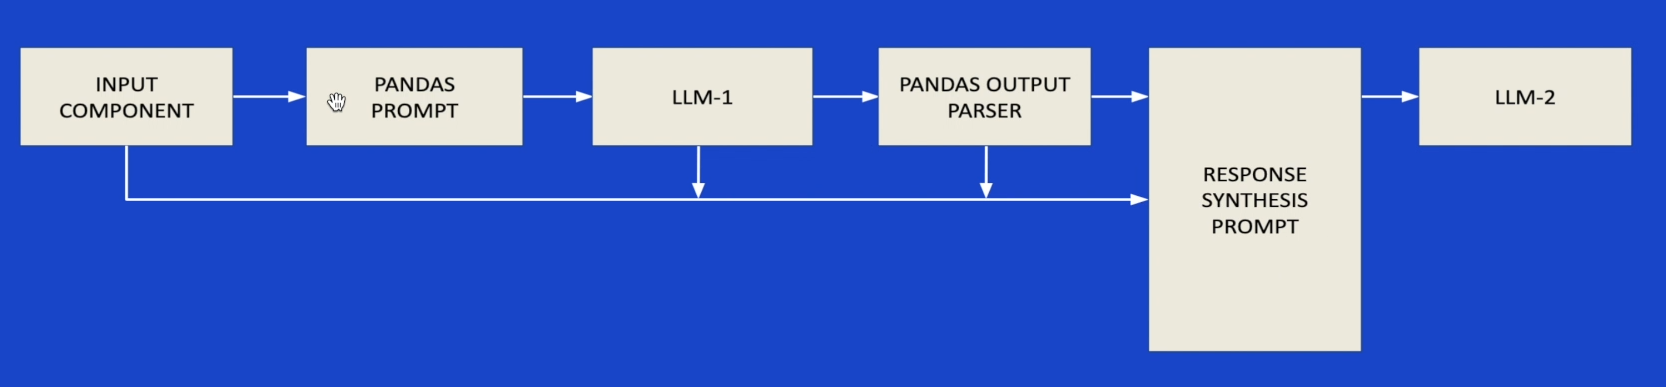

In [7]:
qp.add_chain(["input", "pandas_prompt", "llm1", "pandas_output_parser"])
qp.add_links(
    [
        Link("input", "response_synthesis_prompt", dest_key="query_str"),
        Link(
            "llm1", "response_synthesis_prompt", dest_key="pandas_instructions"
        ),  
        Link(
            "pandas_output_parser",
            "response_synthesis_prompt",
            dest_key="pandas_output",
        ),
    ]
)
# add link from response synthesis prompt to llm2
qp.add_link("response_synthesis_prompt", "llm2")

In [8]:
# Run Query
response = qp.run(
    # query_str="What is the correlation between vegetable Intake and Obesity level? Show the correlation coefficient along with explanation."
    # query_str="What is the distrbution between males and females?",
    query_str="What is the distribution of people consuming alcohol and not?"        
)
print(response)

> Running module input with input: 
query_str: What is the distribution of people consuming alcohol and not?

> Running module pandas_prompt with input: 
query_str: What is the distribution of people consuming alcohol and not?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
    Age  Gender  Height  Weight Alcohol_Consulption High_Calorie_Food  \...

> Running module pandas_output_parser with input: 
input: assistant: df['Alcohol_Consulption'].value_counts()

> Running module response_synthesis_prompt with input: 
query_str: What is the distribution of people consuming alcohol and not?
pandas_instructions: assistant: df['Alcohol_Consulption'].value_counts()
pandas_output: Alcohol_Consulption
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

> Running module llm2 with input: 
messages: Given an input question, s